## Load and clean data

In [2]:
# run only if jupyterthemes installed
from jupyterthemes import jtplot
jtplot.style(theme='gruvboxd')
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))
jtplot.reset()

In [3]:
import os
cwd = os.getcwd()

import pandas as pd

# read excel spreadsheet into a dataframe
raw = pd.read_excel(cwd + '/MAYO-01-17VW Client Data Tables and Stats Mouse Feces.xlsx', 
                    header=None, sheet_name=1, usecols="B, F, N:W", 
                    skiprows=lambda x: x in [0, 1, 2, 3, 4, 6],
                   engine = 'openpyxl')
raw.head()

,1,5,13,14,15,16,17,18,19,20,21,22
0,NaN,NaN,Day 7,Week 12,Day 7,Week 12,Day 7,Week 12,Day 7,Week 12,Day 7,Week 12
1,(12 or 13)-methylmyristate (a15:0 or i15:0),LC/MS Neg,127452336,398733600,194414640,205534192,190075648,368667328,363972864,177412320,261315008,267093568
2,(14 or 15)-methylpalmitate (a17:0 or i17:0),LC/MS Neg,13088862,17803722,16050609,16540071,24838720,21238488,18666004,13516261,15583477,15641594
3,(16 or 17)-methylstearate (a19:0 or i19:0),LC/MS Neg,1849648,1881931,1832783,2877598,3745333,3074163,2926198,1760097,1750348,2235711
4,(3'-5')-adenylyladenosine*,LC/MS Neg,85744,NaN,30137,NaN,112979,174232,104255,NaN,82381,NaN


In [4]:
platforms = ['LC/MS Neg', 'LC/MS Pos Early', 'LC/MS Pos Late', 'LC/MS Polar']

def clean(df):
  """
  Processes the raw excel spreadsheet dataframe with pandas. Returns a dict
  that has keys that correspond to mass spec platforms and values that correspond
  to the matrix with the columns representing the metabolite measurements 
  that were obtained with that platform
  """
  sampleDict = {}
  firstRow = df.iloc[[0], :]

  for platform in platforms:
    platformSample = pd.concat((firstRow, df[df[5] == platform]))
    platformSample = platformSample.drop(labels=[5], axis=1)
  
    transposed = platformSample.transpose()
    transposed.reset_index(drop=True, inplace=True)
  
    # use first row as header
    # https://stackoverflow.com/a/31328974/14772896
    new_header = transposed.iloc[0] #grab the first row for the header
    transposed = transposed[1:] #take the data less the header row
    transposed.columns = new_header #set the header row as the df header
    transposed.reset_index(drop=True, inplace=True)
  
    # Make a target column based on whether or not the sample was taken in Week 12
    transposed.insert(0, 'AfterProbiotic', transposed.iloc[:, 0] == 'Week 12', allow_duplicates=False)
    transposed = transposed.loc[:, transposed.columns.notnull()]
    transposed.index.name = None

    transposed.iloc[:, 0] = transposed.iloc[:, 0].astype(int)
    sampleDict[platform] = transposed.apply(pd.to_numeric)
  return sampleDict

In [5]:
cleanedDict = clean(raw)
cleanedDict['LC/MS Neg'].head()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,...,undecanedioate (C11-DC),uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,vanillactate,vanillate,xanthosine,xanthurenate
0,0,127452336,13088862,1849648,85744.0000,34092.0,85874.0,97642.0000,31036.0,93433.0000,...,660328.000,33665008.0,69467.0000,17629108,3713509,5598799.0,141336.0000,1.937091e+06,168667.0000,4.616876e+06
1,1,398733600,17803722,1881931,NaN,NaN,NaN,NaN,NaN,24328.0000,...,997748.000,6564965.5,NaN,45081784,3678150,691263.0,NaN,4.572610e+05,23525.0000,1.409255e+06
2,0,194414640,16050609,1832783,30136.9980,NaN,36636.0,45126.0000,NaN,53159.0039,...,806952.000,23000954.0,54292.9961,20868878,12475891,2339856.0,60392.0039,1.033449e+06,114592.0000,1.971338e+06
3,1,205534192,16540071,2877598,NaN,NaN,NaN,NaN,NaN,NaN,...,1826000.125,11619855.0,NaN,43900560,7151141,420003.0,38306.0000,2.474280e+05,323089.0000,1.017439e+06
4,0,190075648,24838720,3745333,112979.0078,105128.0,135324.0,225216.0156,NaN,203341.0000,...,815633.000,38883532.0,280257.0000,20869146,11350769,9800247.0,142499.0000,1.750452e+06,174361.9844,6.399171e+06


In [6]:
for d in cleanedDict.values():
  print(d.isnull().sum().sum())

214
63
148
13


In [7]:
def impute(df):
  """
  Replaces each NAN element in each row with x, where x is the minimum value of sample / 2
  """
  return df.apply(lambda row: row.fillna(row.min() / 2), axis=1)


In [8]:
imputedDict = {key : pd.concat([value.iloc[:, 0], impute(value.iloc[:, 1:])], axis=1) for key, value in cleanedDict.items()}
imputedDict[platforms[0]].head()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,...,undecanedioate (C11-DC),uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,vanillactate,vanillate,xanthosine,xanthurenate
0,0,127452336.0,13088862.0,1849648.0,85744.0000,34092.0,85874.0,97642.0000,31036.0,93433.0000,...,660328.000,33665008.0,69467.0000,17629108.0,3713509.0,5598799.0,141336.0000,1.937091e+06,168667.0000,4.616876e+06
1,1,398733600.0,17803722.0,1881931.0,6919.5000,6919.5,6919.5,6919.5000,6919.5,24328.0000,...,997748.000,6564965.5,6919.5000,45081784.0,3678150.0,691263.0,6919.5000,4.572610e+05,23525.0000,1.409255e+06
2,0,194414640.0,16050609.0,1832783.0,30136.9980,8408.0,36636.0,45126.0000,8408.0,53159.0039,...,806952.000,23000954.0,54292.9961,20868878.0,12475891.0,2339856.0,60392.0039,1.033449e+06,114592.0000,1.971338e+06
3,1,205534192.0,16540071.0,2877598.0,10238.5000,10238.5,10238.5,10238.5000,10238.5,10238.5000,...,1826000.125,11619855.0,10238.5000,43900560.0,7151141.0,420003.0,38306.0000,2.474280e+05,323089.0000,1.017439e+06
4,0,190075648.0,24838720.0,3745333.0,112979.0078,105128.0,135324.0,225216.0156,8904.5,203341.0000,...,815633.000,38883532.0,280257.0000,20869146.0,11350769.0,9800247.0,142499.0000,1.750452e+06,174361.9844,6.399171e+06


In [9]:
for d in imputedDict.values():
  print(d.isnull().sum().sum())

0
0
0
0


In [10]:
def scale(df):
  """
  For each sample, divides each element by the sum of the elements in the sample
  """
  return df.apply(lambda row: row / row.sum(), axis=1)

In [11]:
scaledDict = {key : pd.concat([value.iloc[:, 0], scale(value.iloc[:, 1:])], axis=1) for key, value in imputedDict.items()}
scaledDict[platforms[0]].head()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,...,undecanedioate (C11-DC),uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,vanillactate,vanillate,xanthosine,xanthurenate
0,0,0.009515,0.000977,0.000138,6.401146e-06,2.545109e-06,6.410851e-06,7.289381e-06,2.316966e-06,6.975162e-06,...,0.000049,0.002513,5.186000e-06,0.001316,0.000277,0.000418,1.055132e-05,0.000145,0.000013,0.000345
1,1,0.025050,0.001119,0.000118,4.347130e-07,4.347130e-07,4.347130e-07,4.347130e-07,4.347130e-07,1.528390e-06,...,0.000063,0.000412,4.347130e-07,0.002832,0.000231,0.000043,4.347130e-07,0.000029,0.000001,0.000089
2,0,0.014235,0.001175,0.000134,2.206632e-06,6.156341e-07,2.682490e-06,3.304128e-06,6.156341e-07,3.892305e-06,...,0.000059,0.001684,3.975336e-06,0.001528,0.000913,0.000171,4.421905e-06,0.000076,0.000008,0.000144
3,1,0.017041,0.001371,0.000239,8.488992e-07,8.488992e-07,8.488992e-07,8.488992e-07,8.488992e-07,8.488992e-07,...,0.000151,0.000963,8.488992e-07,0.003640,0.000593,0.000035,3.176045e-06,0.000021,0.000027,0.000084
4,0,0.010733,0.001403,0.000211,6.379746e-06,5.936412e-06,7.641532e-06,1.271759e-05,5.028230e-07,1.148234e-05,...,0.000046,0.002196,1.582567e-05,0.001178,0.000641,0.000553,8.046693e-06,0.000099,0.000010,0.000361


In [12]:
import numpy as np

def transform(df):
  """ 
  Apply arcsine transformation on all values
  """  
  newdf = df.copy()
  newdf = np.arcsin(np.sqrt(newdf))
  return newdf

In [13]:
transformedDict = {key : pd.concat([value.iloc[:, 0], transform(value.iloc[:, 1:])], axis=1) for key, value in scaledDict.items()}
transformedDict[platforms[0]].head()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,...,undecanedioate (C11-DC),uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,vanillactate,vanillate,xanthosine,xanthurenate
0,0,0.097699,0.031264,0.011751,0.002530,0.001595,0.002532,0.002700,0.001522,0.002641,...,0.007021,0.050153,0.002277,0.036286,0.016651,0.020446,0.003248,0.012026,0.003548,0.018566
1,1,0.158941,0.033450,0.010874,0.000659,0.000659,0.000659,0.000659,0.000659,0.001236,...,0.007917,0.020310,0.000659,0.053244,0.015202,0.006590,0.000659,0.005360,0.001216,0.009409
2,0,0.119596,0.034288,0.011585,0.001485,0.000785,0.001638,0.001818,0.000785,0.001973,...,0.007687,0.041050,0.001994,0.039100,0.030229,0.013089,0.002103,0.008699,0.002897,0.012015
3,1,0.130916,0.037041,0.015447,0.000921,0.000921,0.000921,0.000921,0.000921,0.000921,...,0.012305,0.031044,0.000921,0.060368,0.024352,0.005901,0.001782,0.004529,0.005176,0.009185
4,0,0.103788,0.037460,0.014543,0.002526,0.002436,0.002764,0.003566,0.000709,0.003389,...,0.006787,0.046875,0.003978,0.034335,0.025320,0.023527,0.002837,0.009942,0.003138,0.019010


In [14]:
transformedDict[platforms[0]].describe()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,...,undecanedioate (C11-DC),uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,vanillactate,vanillate,xanthosine,xanthurenate
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.500000,0.134477,0.035152,0.013010,0.001919,0.001467,0.002033,0.002141,0.001075,0.002358,...,0.008298,0.038560,0.002481,0.041874,0.019359,0.015239,0.002210,0.008721,0.003498,0.013373
std,0.527046,0.027194,0.003424,0.001857,0.001026,0.000694,0.001128,0.001230,0.000519,0.001072,...,0.002159,0.008750,0.001521,0.008462,0.006796,0.006634,0.000901,0.002681,0.001261,0.003987
min,0.000000,0.097699,0.030752,0.010874,0.000659,0.000659,0.000659,0.000659,0.000659,0.000832,...,0.005755,0.020310,0.000659,0.034335,0.008571,0.005901,0.000659,0.004529,0.001216,0.009185
25%,0.000000,0.113618,0.031811,0.011626,0.000956,0.000854,0.000956,0.000924,0.000796,0.001420,...,0.006845,0.034058,0.001076,0.036590,0.015564,0.008753,0.001862,0.006195,0.002957,0.010198
50%,0.500000,0.130085,0.035616,0.012424,0.002006,0.001328,0.002085,0.002259,0.000928,0.002512,...,0.007802,0.039661,0.002136,0.039073,0.020776,0.016849,0.002352,0.009807,0.003470,0.011467
75%,1.000000,0.157830,0.037355,0.014421,0.002757,0.002150,0.003018,0.003351,0.001031,0.003321,...,0.008885,0.044539,0.003907,0.042666,0.023668,0.020509,0.002831,0.010504,0.004166,0.017079
max,1.000000,0.178249,0.040164,0.015899,0.003345,0.002436,0.003578,0.003566,0.002385,0.003567,...,0.012305,0.050153,0.004776,0.060368,0.030229,0.023527,0.003248,0.012026,0.005392,0.019010


Combine the four matrices

In [15]:
final = transformedDict[platforms[0]]

for platform in platforms[1:]:
  final = pd.concat((final, transformedDict[platform].iloc[:, 1:]), axis=1)
final.head()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,...,ribulose/xylulose,salicylate,sedoheptulose,suberate (C8-DC),succinate,succinimide,threonate,tricarballylate,urate,xylose
0,0,0.097699,0.031264,0.011751,0.002530,0.001595,0.002532,0.002700,0.001522,0.002641,...,0.061728,0.022498,0.040729,0.024735,0.347333,0.021981,0.155677,0.241432,0.048367,0.149068
1,1,0.158941,0.033450,0.010874,0.000659,0.000659,0.000659,0.000659,0.000659,0.001236,...,0.065172,0.019992,0.034188,0.042743,0.374643,0.033852,0.088292,0.078611,0.044431,0.180184
2,0,0.119596,0.034288,0.011585,0.001485,0.000785,0.001638,0.001818,0.000785,0.001973,...,0.061133,0.021559,0.060845,0.033103,0.286650,0.030653,0.116940,0.197009,0.045180,0.168328
3,1,0.130916,0.037041,0.015447,0.000921,0.000921,0.000921,0.000921,0.000921,0.000921,...,0.056082,0.018504,0.091777,0.035994,0.442962,0.022208,0.078139,0.105422,0.032510,0.140046
4,0,0.103788,0.037460,0.014543,0.002526,0.002436,0.002764,0.003566,0.000709,0.003389,...,0.034491,0.025123,0.034373,0.032385,0.286454,0.028730,0.195996,0.328468,0.057677,0.072740


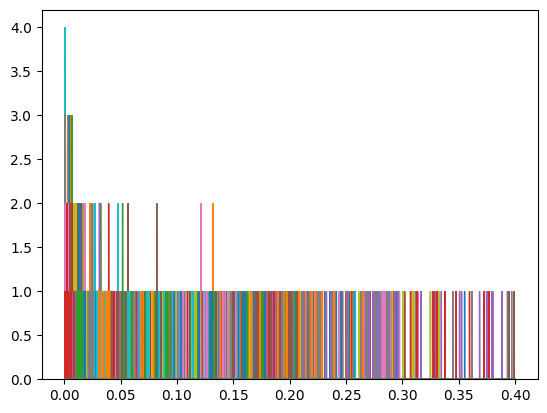

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(final.iloc[:, 1:],histtype='step', bins=10000, range=[0, 0.4])
plt.show()


In [17]:
final['mouseID'] = (np.arange(len(final)) // 2) + 1
final['isMale'] =  [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
final

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,...,sedoheptulose,suberate (C8-DC),succinate,succinimide,threonate,tricarballylate,urate,xylose,mouseID,isMale
0,0,0.097699,0.031264,0.011751,0.002530,0.001595,0.002532,0.002700,0.001522,0.002641,...,0.040729,0.024735,0.347333,0.021981,0.155677,0.241432,0.048367,0.149068,1,1
1,1,0.158941,0.033450,0.010874,0.000659,0.000659,0.000659,0.000659,0.000659,0.001236,...,0.034188,0.042743,0.374643,0.033852,0.088292,0.078611,0.044431,0.180184,1,1
2,0,0.119596,0.034288,0.011585,0.001485,0.000785,0.001638,0.001818,0.000785,0.001973,...,0.060845,0.033103,0.286650,0.030653,0.116940,0.197009,0.045180,0.168328,2,1
3,1,0.130916,0.037041,0.015447,0.000921,0.000921,0.000921,0.000921,0.000921,0.000921,...,0.091777,0.035994,0.442962,0.022208,0.078139,0.105422,0.032510,0.140046,2,1
4,0,0.103788,0.037460,0.014543,0.002526,0.002436,0.002764,0.003566,0.000709,0.003389,...,0.034373,0.032385,0.286454,0.028730,0.195996,0.328468,0.057677,0.072740,3,1
5,1,0.154498,0.036943,0.014053,0.003345,0.002256,0.003578,0.003453,0.002385,0.003525,...,0.058926,0.044877,0.361670,0.031210,0.124713,0.139020,0.063091,0.093225,3,1
6,0,0.178249,0.040164,0.015899,0.003001,0.002235,0.003103,0.003046,0.000941,0.003117,...,0.021816,0.030599,0.344763,0.029454,0.153957,0.253468,0.063587,0.118900,4,0
7,1,0.111626,0.030752,0.011096,0.000832,0.000832,0.000832,0.000832,0.000832,0.000832,...,0.021584,0.033518,0.245637,0.020587,0.185380,0.159851,0.082961,0.101554,4,0
8,0,0.160207,0.038966,0.013056,0.002832,0.001893,0.003246,0.000934,0.000934,0.002383,...,0.026331,0.027682,0.240438,0.023459,0.121336,0.197046,0.052422,0.287363,5,0
9,1,0.129253,0.031197,0.011793,0.001061,0.001061,0.001061,0.003476,0.001061,0.003567,...,0.023904,0.030442,0.216346,0.024343,0.199169,0.174640,0.081636,0.055060,5,0


In [18]:
final.to_csv('output/data.csv', index=False)

## Linear Model Setup

In [29]:
%cd output

/Users/daniel/Documents/School/2020-2021/Spring/Research/FecalMetabolomics/output


In [30]:
! mkdir data

In [36]:
# For each biochemical, create a csv file with just that biochemical

for column in range(1, 824):
  df = final.iloc[:, [0, column, 824, 825]].copy()
  # change name of the biochem column to abundance
  df['abundance'] = df[df.columns[1]]
  df = df.drop(columns=[df.columns[1]])
  df.to_csv("data/%d.txt" % (column))

In [37]:
%load_ext rpy2.ipython

R[write to console]: Error in value[[3L]](cond) : 
  unable to load shared object '/Users/daniel/opt/anaconda3/envs/data/lib/R/library/methods/libs/methods.so':
  dlopen(/Users/daniel/opt/anaconda3/envs/data/lib/R/library/methods/libs/methods.so, 6): Library not loaded: @rpath/libreadline.6.2.dylib
  Referenced from: /Users/daniel/opt/anaconda3/envs/data/lib/R/lib/libR.dylib
  Reason: image not found



RRuntimeError: Error in value[[3L]](cond) : 
  unable to load shared object '/Users/daniel/opt/anaconda3/envs/data/lib/R/library/methods/libs/methods.so':
  dlopen(/Users/daniel/opt/anaconda3/envs/data/lib/R/library/methods/libs/methods.so, 6): Library not loaded: @rpath/libreadline.6.2.dylib
  Referenced from: /Users/daniel/opt/anaconda3/envs/data/lib/R/lib/libR.dylib
  Reason: image not found


In [26]:
import rpy2.ipython.html
rpy2.ipython.html.init_printing()

In [27]:
! mkdir p_values

mkdir: cannot create directory ‘p_values’: File exists


## Model 1: dependent variable is metabolite; independent variable is time-point.


In [28]:
! mkdir p_values/m1

mkdir: cannot create directory ‘p_values/m1’: File exists


In [29]:
%%R
p_vals_m1 = data.frame(
   p_val = c(1:823)
)

In [30]:
%%R

get_p_val_m1 = function(data) {
    model = lm(abundance ~ AfterProbiotic, data=data, family=binomial)
    coef = coef(summary(model))[,4]
    p_val = coef[2]
    return (p_val)
}

In [31]:
%%R
d = read.csv(file=paste("/content/data/", 1, '.txt', sep=""))
get_p_val_m1(d)

AfterProbiotic 
     0.7842764 


In [32]:
%%R
for (id in 1:823) {
  data = read.csv(file= paste("/content/data/", id, '.txt', sep=""))
  p_val = tryCatch(
      get_p_val_m1(data),
      error=function(e) {return (1)}
  )
  p_vals_m1[id, 1] = p_val
}

In [33]:
%%R
head(p_vals_m1)

       p_val
1 0.78427639
2 0.26153344
3 0.57429065
4 0.08475590
5 0.15217360
6 0.07744751


In [34]:
%%R
write.csv(p_vals_m1, "p_values/m1/p_vals_time.csv")

## Model 2: dependent variable is metabolite; independent variables are time-point and mouse sex.

In [35]:
! mkdir p_values/m2

mkdir: cannot create directory ‘p_values/m2’: File exists


In [36]:
%%R

p_vals_m2_time = data.frame(
   p_val = c(1:823)
)
p_vals_m2_sex = data.frame(
   p_val = c(1:823)
)

In [37]:
%%R

get_p_vals_m2 = function(data) {
    model = lm(abundance ~ AfterProbiotic + isMale, data=data, family=binomial)
    coef = coef(summary(model))[,4]
    p_val_time = coef[2]
    p_val_sex = coef[3]
    return (list(p_val_time, p_val_sex))
}

In [38]:
%%R
d = read.csv(file=paste("/content/data/", 1, '.txt', sep=""))
plist = get_p_vals_m2(d)
plist

[[1]]
AfterProbiotic 
     0.7872136 

[[2]]
   isMale 
0.3866779 



In [39]:
%%R
for (id in 1:823) {
  data = read.csv(file= paste("/content/data/", id, '.txt', sep=""))
  p_val_list = tryCatch(
      get_p_vals_m2(data),
      error=function(e) {return (list(1, 1))}
  )
  p_vals_m2_time[id, 1] = p_val_list[1]
  p_vals_m2_sex[id, 1] = p_val_list[2]
}

In [40]:
%%R
head(p_vals_m2_time)

       p_val
1 0.78721358
2 0.29547503
3 0.60077369
4 0.10835108
5 0.18176135
6 0.09995548


In [41]:
%%R

head(p_vals_m2_sex)

      p_val
1 0.3866779
2 0.9349330
3 0.9530354
4 0.9745062
5 0.8905023
6 0.9485944


In [42]:
%%R

write.csv(p_vals_m2_time, "p_values/m2/p_vals_time.csv")
write.csv(p_vals_m2_sex, "p_values/m2/p_vals_sex.csv")

## Model 3: dependent variable is metabolite; independent variables are time-point and mouse sex, and also control for mouseID as a random-effect (use 'lmer' function with (1|mouseID).

In [43]:
! mkdir p_values/m3

mkdir: cannot create directory ‘p_values/m3’: File exists


In [ ]:
%%R

install.packages("lmerTest")

In [44]:
%%R

p_vals_m3_time = data.frame(
   p_val = c(1:823)
)
p_vals_m3_sex = data.frame(
   p_val = c(1:823)
)

In [ ]:
%%R

library(lmerTest)
get_p_vals_m3 = function(data) {
    model = lmer(abundance ~ AfterProbiotic + isMale + (1|mouseID), data=data)
    coef = coef(summary(model))[,5]
    p_val_time = coef[2]
    p_val_sex = coef[3]
    return (list(p_val_time, p_val_sex))
}

In [46]:
%%R
d = read.csv(file=paste("/content/data/", 1, '.txt', sep=""))
get_p_vals_m3(d)

R[write to console]: boundary (singular) fit: see ?isSingular



[[1]]
AfterProbiotic 
     0.7872136 

[[2]]
   isMale 
0.3866779 



In [ ]:
%%R
for (id in 1:823) {
  data = read.csv(file= paste("/content/data/", id, '.txt', sep=""))
  p_val_list = tryCatch(
      get_p_vals_m3(data),
      error=function(e) {return (list(1, 1))}
  )
  p_vals_m3_time[id, 1] = p_val_list[1]
  p_vals_m3_sex[id, 1] = p_val_list[2]
}

In [48]:
%%R 

head(p_vals_m3_time)

      p_val
1 0.7872136
2 0.2954750
3 0.6007737
4 0.1158122
5 0.0801481
6 0.1002768


In [49]:
%%R

head(p_vals_m3_sex)

      p_val
1 0.3866779
2 0.9349330
3 0.9530354
4 0.9778500
5 0.9218480
6 0.9565760


In [50]:
%%R

write.csv(p_vals_m3_time, "p_values/m3/p_vals_time.csv")
write.csv(p_vals_m3_sex, "p_values/m3/p_vals_sex.csv")

## Analysis

In [61]:
biochemicals = list(final.columns[1:-2])

In [65]:
from statsmodels.stats.multitest import fdrcorrection

def correct(df):
  """
  Returns a dataframe with the pvals corrected for fdr
  """
  num = df.iloc[:, 0].to_numpy()
  corrected = fdrcorrection(num)[1]
  newdf = df.copy()
  newdf.iloc[:, 0] = corrected
  return newdf

In [66]:
def addBiochemicals(df):
  """ Uses global variable 'biochemicals' to replace row indicies with biochemical
  names"""
  copy = df.copy()
  copy.index = biochemicals
  return copy

Model 1

In [67]:
p_vals_m1_time = addBiochemicals(pd.read_csv('p_values/m1/p_vals_time.csv')).iloc[:, [1]]

In [68]:
p_vals_m1_time.nsmallest(5, 'p_val')

,p_val
myristoleate (14:1n5),0.000172
malate,0.000181
N-palmitoylglycine,0.000452
5-hydroxyhexanoate,0.000458
mannitol/sorbitol,0.000659


In [69]:
correct(p_vals_m1_time).nsmallest(5, 'p_val')

,p_val
malate,0.074655
myristoleate (14:1n5),0.074655
5-hydroxyhexanoate,0.094151
N-palmitoylglycine,0.094151
pheophytin A,0.098834


Model 2

In [70]:
p_vals_m2_time = addBiochemicals(pd.read_csv('p_values/m2/p_vals_time.csv')).iloc[:, [1]]
p_vals_m2_sex = addBiochemicals(pd.read_csv('p_values/m2/p_vals_sex.csv')).iloc[:, [1]]

In [71]:
p_vals_m2_time.nsmallest(5, 'p_val')

,p_val
myristoleate (14:1n5),0.000360
malate,0.000402
2-isopropylmalate,0.000553
palmitoleoyl ethanolamide*,0.000600
serotonin,0.000630


In [72]:
p_vals_m2_time_corrected = correct(p_vals_m2_time)
p_vals_m2_time_corrected.nsmallest(5, 'p_val')

,p_val
5-hydroxyhexanoate,0.088764
malate,0.088764
myristoleate (14:1n5),0.088764
N-palmitoylglycine,0.088764
N-acetyl-3-methylhistidine*,0.088764


In [73]:
p_vals_m2_sex.nsmallest(5, 'p_val')

,p_val
3-formylindole,0.000202
"sphingomyelin (d18:1/24:1, d18:2/24:0)*",0.000236
N-acetylthreonine,0.000295
cystathionine,0.000448
N-acetylcitrulline,0.000475


In [74]:
correct(p_vals_m2_sex).nsmallest(5, 'p_val')

,p_val
3-formylindole,0.077028
heneicosapentaenoate (21:5n3),0.077028
indolelactate,0.077028
N-acetylcitrulline,0.077028
N-acetylthreonine,0.077028


Model 3

In [75]:
p_vals_m3_time = addBiochemicals(pd.read_csv('p_values/m3/p_vals_time.csv')).iloc[:, [1]]
p_vals_m3_sex = addBiochemicals(pd.read_csv('p_values/m3/p_vals_sex.csv')).iloc[:, [1]]

In [76]:
p_vals_m3_time.nsmallest(5, 'p_val')

,p_val
5-methyl-2'-deoxycytidine,0.000025
myristoleate (14:1n5),0.000360
palmitoleoyl ethanolamide*,0.000600
N-acetyl-3-methylhistidine*,0.000762
pheophytin A,0.000826


In [77]:
p_vals_m3_time_corrected = correct(p_vals_m3_time)
p_vals_m3_time_corrected.nsmallest(5, 'p_val')

,p_val
5-methyl-2'-deoxycytidine,0.020287
glycocholate sulfate,0.124464
myristoleate (14:1n5),0.124464
N-acetyl-3-methylhistidine*,0.124464
palmitoleoyl ethanolamide*,0.124464


In [78]:
p_vals_m3_sex.nsmallest(5, 'p_val')

,p_val
3-formylindole,0.000202
N-acetylcitrulline,0.000475
cysteine,0.000863
indolelactate,0.000978
maltose,0.001153


In [79]:
correct(p_vals_m3_sex).nsmallest(5, 'p_val')

,p_val
3-formylindole,0.166308
indolelactate,0.166308
N-acetylcitrulline,0.166308
cysteine,0.166308
N-acetyl-3-methylhistidine*,0.166308


## Export model 2 and 3 pvals

In [80]:
model2_pvals = p_vals_m2_time_corrected.loc[p_vals_m2_time_corrected['p_val'] < 0.2].sort_values(by=['p_val'])
model2_pvals.head()

,p_val
2-isopropylmalate,0.088764
pheophytin A,0.088764
palmitoleoyl ethanolamide*,0.088764
serotonin,0.088764
N-acetyl-3-methylhistidine*,0.088764


In [81]:
model3_pvals = p_vals_m3_time_corrected.loc[p_vals_m3_time_corrected['p_val'] < 0.2].sort_values(by=['p_val'])
model3_pvals.head()

,p_val
5-methyl-2'-deoxycytidine,0.020287
myristoleate (14:1n5),0.124464
N-acetyl-3-methylhistidine*,0.124464
glycocholate sulfate,0.124464
pheophytin A,0.124464


In [82]:
len(model2_pvals), len(model3_pvals)

(107, 118)

In [83]:
model2_pvals.to_csv('model2_pvals.csv')
model3_pvals.to_csv('model3_pvals.csv')